In [1]:
%pip install scikit-learn --upgrade

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, cross_val_score

In [3]:
df = pd.read_csv("/Users/mohamoud/Desktop/test application/Bengaluru_House_Data.csv")
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:
df = df.drop(['area_type', 'availability', 'society', 'balcony'], axis='columns')
df = df.dropna()
df.head(1)

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07


In [6]:
df['bhk'] = df['size'].apply(lambda x: int(x.split()[0]))
df['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [7]:
def convert_sqft_to_num(x):
  tokens = x.split('-')
  if len(tokens) == 2:
    return (float(tokens[0]) + float(tokens[1]))/2
  try:
    return float(x)
  except:
    return None
df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)

In [8]:
location_stats = df.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
Whitefield                        534
Sarjapur  Road                    392
Electronic City                   302
Kanakpura Road                    266
Thanisandra                       233
                                 ... 
 Whitefield                         1
1st Stage Domlur                    1
1st Stage Radha Krishna Layout      1
Wheelers Road                       1
Byappanahalli                       1
Name: location, Length: 1304, dtype: int64

In [9]:
location_stats_less_than_10 = location_stats[location_stats <= 10]
location_stats_less_than_10

location
Dairy Circle                      10
Dodsworth Layout                  10
Ganga Nagar                       10
Sadashiva Nagar                   10
Nagadevanahalli                   10
                                  ..
 Whitefield                        1
1st Stage Domlur                   1
1st Stage Radha Krishna Layout     1
Wheelers Road                      1
Byappanahalli                      1
Name: location, Length: 1063, dtype: int64

In [10]:
df['location'] = df['location'].apply(lambda x: 'Other' if x in location_stats_less_than_10 else x)
df[df['location'] == 'Other']

,location,size,total_sqft,bath,price,bhk
9,Other,6 Bedroom,1020.0,6.0,370.00,6
18,Other,3 BHK,2770.0,4.0,290.00,3
19,Other,2 BHK,1100.0,2.0,48.00,2
24,Other,1 RK,510.0,1.0,25.25,1
25,Other,3 BHK,1250.0,3.0,56.00,3
...,...,...,...,...,...,...
13291,Other,1 Bedroom,812.0,1.0,26.00,1
13292,Other,3 BHK,1440.0,2.0,63.93,3
13302,Other,2 BHK,1075.0,2.0,48.00,2
13306,Other,4 Bedroom,1200.0,5.0,325.00,4


In [11]:
df.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [12]:
len(df)

13246

In [13]:
df = df[~(df['total_sqft']/df['bhk']<300)]
len(df)

12502

In [14]:
df['price_per_sqft'] = (df['price']*100000)/df['total_sqft']
df['price_per_sqft'].describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [15]:
def remove_pps_outliers(data_frame):
  df_out = pd.DataFrame()
  for key, subdf in data_frame.groupby('location'):
    m = np.mean(subdf['price_per_sqft'])
    sd = np.std(subdf['price_per_sqft'])
    reduced_df = subdf[(subdf['price_per_sqft'] > (m - sd)) & (subdf['price_per_sqft'] < (m + sd))]
    df_out = pd.concat([df_out, reduced_df], ignore_index=True)
  return df_out

In [16]:
len(df)

12502

In [17]:
df = remove_pps_outliers(df)
len(df)

10244

In [18]:
def plot_scatter_chart(data_frame, location):
  bhk2 = df[(df['bhk'] == 2) & (df['location'] == location)]
  bhk3 = df[df['bhk'] == 3 & (df['location'] == location)]
  matplotlib.rcParams['figure.figsize'] = (15, 10)
  plt.scatter(bhk2['total_sqft'], bhk2['price'], color='blue', label='2 BHK', s=50)
  plt.scatter(bhk3['total_sqft'], bhk3['price'], color='green', label='3 BHK', s=50)
  plt.xlabel('Total Square Feet Area')
  plt.ylabel('Price')
  plt.legend()

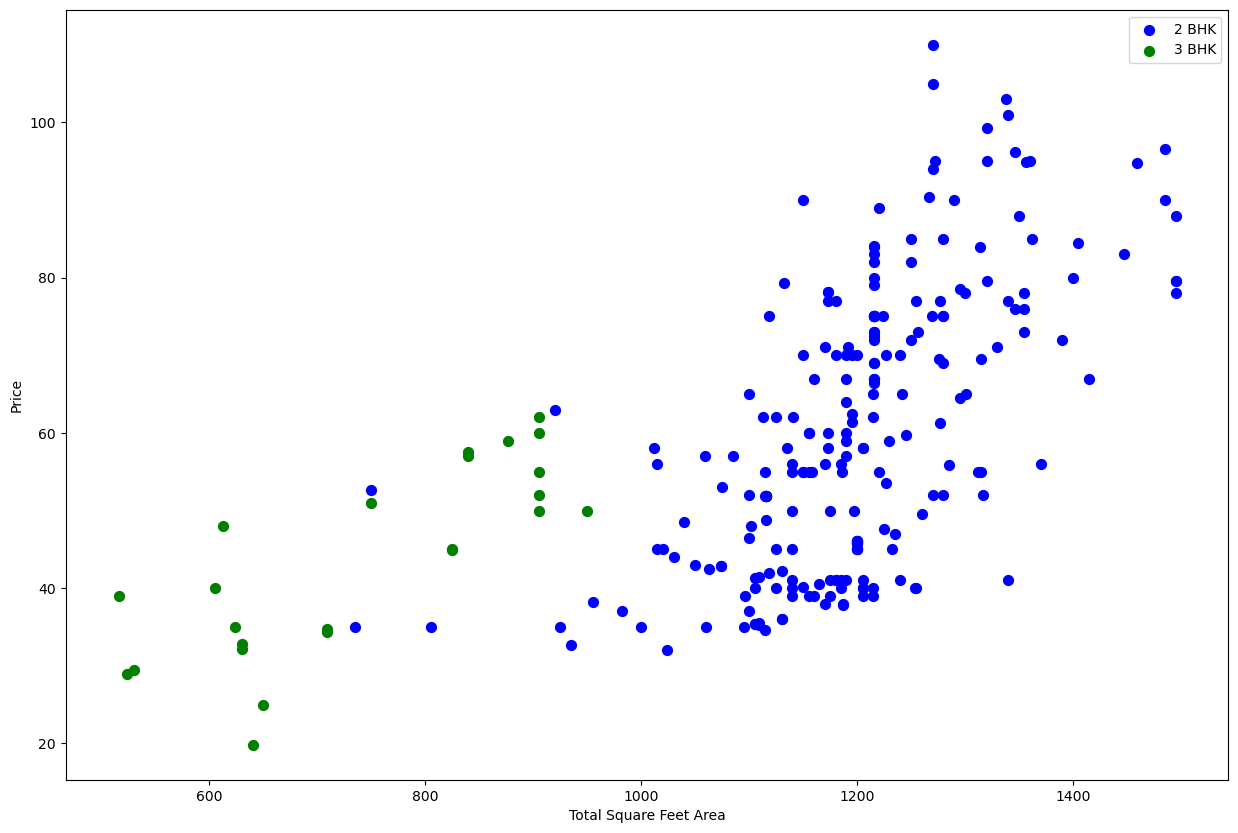

In [19]:
plot_scatter_chart(df, 'Whitefield')

In [20]:
def remove_bhk_outliers(data_frame):
  exclude_indices = np.array([])
  for location, location_df in df.groupby('location'):
    bhk_stats = {}
    for bhk, bhk_df in location_df.groupby('bhk'):
      bhk_stats[bhk] = {
          'mean': np.mean(bhk_df['price_per_sqft']),
          'std': np.std(bhk_df['price_per_sqft']),
          'count': bhk_df.shape[0]
      }
    for bhk, bhk_df in location_df.groupby('bhk'):
      stats = bhk_stats.get(bhk-1)
      if stats and stats['count'] > 5:
        exclude_indices = np.append(exclude_indices, bhk_df[bhk_df['price_per_sqft'] < (stats['mean'])].index.values)
    return df.drop(exclude_indices, axis='index')

In [21]:
len(df)

10244

In [22]:
df = remove_bhk_outliers(df)
df.shape

(10242, 7)

Text(0, 0.5, 'Price')

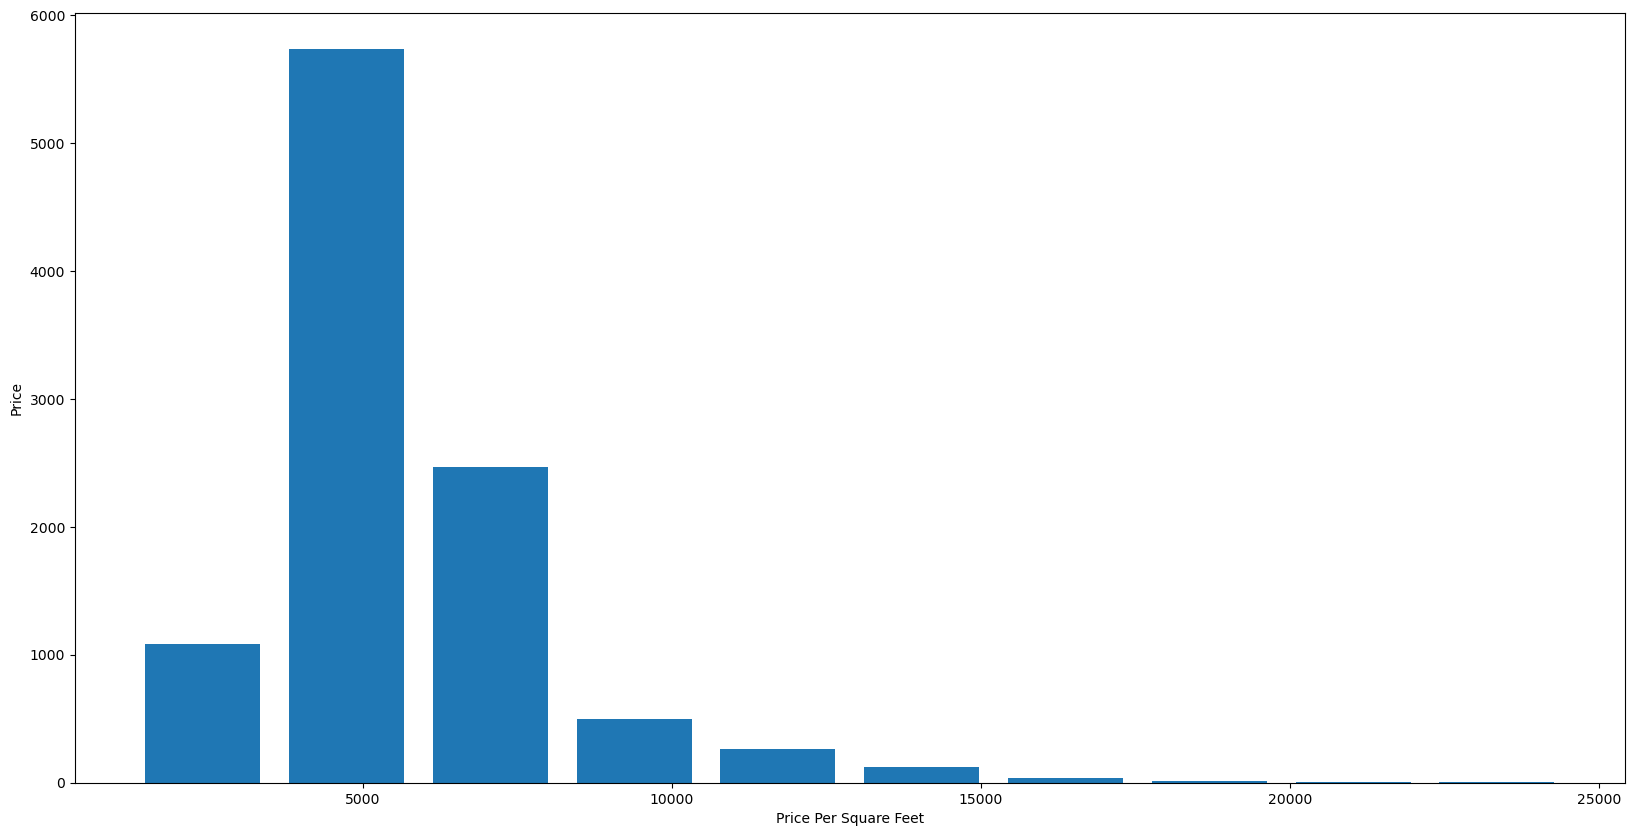

In [23]:
matplotlib.rcParams['figure.figsize'] = (20, 10)
plt.hist(df['price_per_sqft'], rwidth=0.8)
plt.xlabel('Price Per Square Feet')
plt.ylabel('Price')

Text(0, 0.5, 'Count')

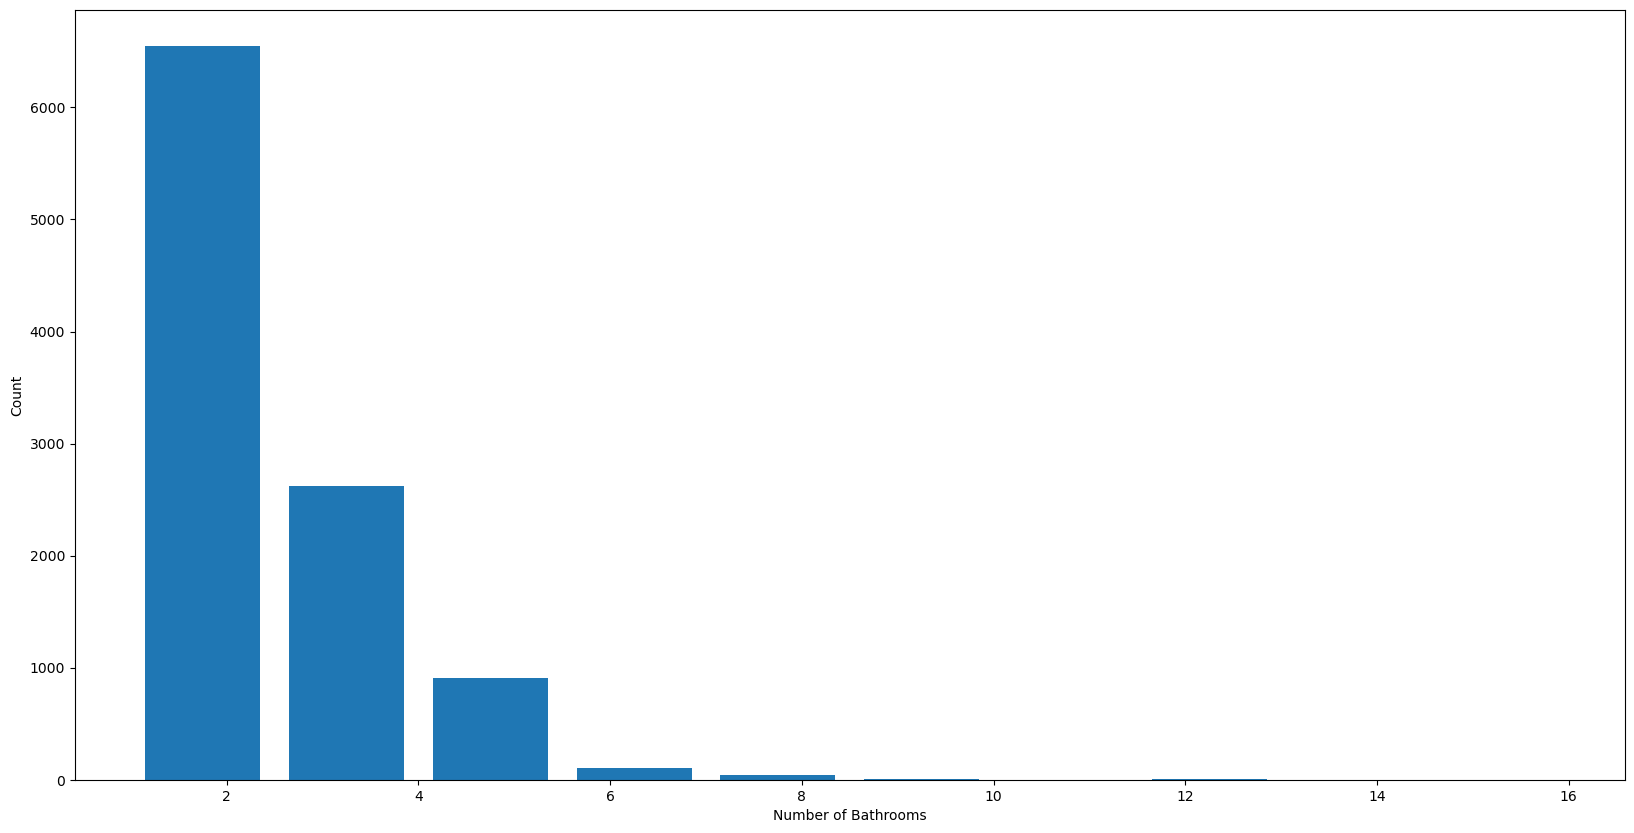

In [24]:
plt.hist(df['bath'], rwidth=0.8)
plt.xlabel('Number of Bathrooms')
plt.ylabel('Count')

In [25]:
df.shape

(10242, 7)

In [26]:
df = df[df['bath'] < df['bhk'] + 2]
df.shape

(10148, 7)

In [27]:
location_dummies = pd.get_dummies(df['location'])
location_dummies

,Devarachikkanahalli,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10239,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
10240,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
10241,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
10242,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [28]:
df = pd.concat([df, location_dummies], axis='columns')
df = df.drop(['location', 'size', 'price_per_sqft'], axis='columns')
df.head(3)

,total_sqft,bath,price,bhk,Devarachikkanahalli,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,1250.0,2.0,40.0,2,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1200.0,2.0,83.0,2,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1170.0,2.0,40.0,2,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [29]:
X = df.drop('price', axis='columns')
X.shape

(10148, 245)

In [30]:
y = df['price']
y.shape

(10148,)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [32]:
lr_clf = LinearRegression()
lr_clf.fit(X_train.values, y_train.values)
lr_clf.score(X_test.values, y_test.values)

0.8628019960067237

In [33]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
scores = cross_val_score(LinearRegression(), X, y, cv=cv)
scores.mean()

0.8133936716516323

In [34]:
def find_best_model(X, y):
  algos = {
      'linear_regression': {
          'model': LinearRegression(),
          'params': {}
      },
      'lasso': {
          'model': Lasso(),
          'params': {
              'alpha': [1, 2],
              'selection': ['random', 'cyclic']
          }
      },
      'decision_tree': {
          'model': DecisionTreeRegressor(),
          'params': {
              'criterion': ['mse', 'friedman_mse'],
              'splitter': ['best', 'random']
          }
      }
  }

  scores = []
  cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
  for algo_name, config in algos.items():
    gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
    gs.fit(X, y)
    scores.append({
        'model': algo_name,
        'best_score': gs.best_score_,
        'best_params': gs.best_params_
    })

  return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

find_best_model(X, y)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1358, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 471, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site-pack

,model,best_score,best_params
0,linear_regression,0.813394,{}
1,lasso,0.687491,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.707383,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


In [35]:
def predict_price(location, sqft, bath, bhk):
  loc_index = np.where(X.columns==location)[0][0]
  x = np.zeros(len(X.columns))
  x[0] = sqft
  x[1] = bath
  x[2] = bhk
  if loc_index >= 0:
    x[loc_index] = 1

  return lr_clf.predict([x])[0]

In [36]:
X.columns

Index(['total_sqft', 'bath', 'bhk', ' Devarachikkanahalli',
       '1st Block Jayanagar', '1st Phase JP Nagar',
       '2nd Phase Judicial Layout', '2nd Stage Nagarbhavi',
       '5th Block Hbr Layout', '5th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=245)

In [37]:
predict_price('1st Block Jayanagar', 500, 2, 2)

149.02039699821256

In [ ]:
with open("model.pickle", 'wb') as f:
    pickle.dump(lr_clf, f)



In [39]:
list(X.columns)[3:]

[' Devarachikkanahalli',
 '1st Block Jayanagar',
 '1st Phase JP Nagar',
 '2nd Phase Judicial Layout',
 '2nd Stage Nagarbhavi',
 '5th Block Hbr Layout',
 '5th Phase JP Nagar',
 '6th Phase JP Nagar',
 '7th Phase JP Nagar',
 '8th Phase JP Nagar',
 '9th Phase JP Nagar',
 'AECS Layout',
 'Abbigere',
 'Akshaya Nagar',
 'Ambalipura',
 'Ambedkar Nagar',
 'Amruthahalli',
 'Anandapura',
 'Ananth Nagar',
 'Anekal',
 'Anjanapura',
 'Ardendale',
 'Arekere',
 'Attibele',
 'BEML Layout',
 'BTM 2nd Stage',
 'BTM Layout',
 'Babusapalaya',
 'Badavala Nagar',
 'Balagere',
 'Banashankari',
 'Banashankari Stage II',
 'Banashankari Stage III',
 'Banashankari Stage V',
 'Banashankari Stage VI',
 'Banaswadi',
 'Banjara Layout',
 'Bannerghatta',
 'Bannerghatta Road',
 'Basavangudi',
 'Basaveshwara Nagar',
 'Battarahalli',
 'Begur',
 'Begur Road',
 'Bellandur',
 'Benson Town',
 'Bharathi Nagar',
 'Bhoganhalli',
 'Billekahalli',
 'Binny Pete',
 'Bisuvanahalli',
 'Bommanahalli',
 'Bommasandra',
 'Bommasandra Indu

In [ ]:
params = {
    'columns': list(X.columns)[3:],
    'prefix': 3
}

with open("params.pickle", 'wb') as f:
    pickle.dump(params, f)
